In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.ticker import MultipleLocator

## Introduction

### Goal

This notebook tries to investigate the **trends** in the gaming market over the last three decades through a detailed analysis based on available data. 

The notebook contains numerous comments aimed at explaining the analysis and decisions made, as well as clarifying potential concerns about the quality of the data.

### Dataset

The dataset contains 8 columns:
- Game title (Name)
- Platform, for which the game was published (Platform)
- The publisher of the game (Publisher)
- The developer of the game (Developer)
- Critic score, scraped from Metacritic (Critic_Score)
- User score, scraped from Metacritic (User_Score)
- Total units sold, in mln copies (Total_Shipped)
- Year of the release (Year)

The full dataset can be found on [Kaggle](https://www.kaggle.com/datasets/holmjason2/videogamedata).

## EDA

### Import data

In [2]:
sales = pd.read_csv('data/game_sales_data.csv')

In [3]:
sales.head()

,Name,Platform,Publisher,Developer,Critic_Score,User_Score,Total_Shipped,Year
0,Wii Sports,Wii,Nintendo,Nintendo EAD,7.7,8.0,82.90,2006
1,Super Mario Bros.,NES,Nintendo,Nintendo EAD,10.0,8.2,40.24,1985
2,Counter-Strike: Global Offensive,PC,Valve,Valve Corporation,8.0,7.5,40.00,2012
3,Mario Kart Wii,Wii,Nintendo,Nintendo EAD,8.2,9.1,37.32,2008
4,PLAYERUNKNOWN'S BATTLEGROUNDS,PC,PUBG Corporation,PUBG Corporation,8.6,4.7,36.60,2017


### Data overview

Are there any duplicates? If so, remove them. I'm using a subset of variables, because a duplicated game may happen to have different reviews/total_shipping for some reason. In such case it won't get detected if all variables are used as a filtering criterion:

In [4]:
print(f"Number of duplicates in sales: {sales.duplicated(subset=['Name','Platform','Developer','Year']).sum()}")
sales.drop_duplicates(inplace=True,subset=['Name','Platform','Developer','Year'])

Number of duplicates in sales: 36


Let's also convert year to Datetime:

In [5]:
sales['Year'] = pd.to_datetime(sales['Year'], format='%Y')

In [6]:
sales.describe()

,Critic_Score,User_Score,Total_Shipped
count,9941.000000,2212.000000,19564.000000
mean,7.033618,6.992586,0.551600
std,1.559922,1.518455,1.672831
min,0.800000,1.000000,0.010000
25%,6.100000,6.300000,0.050000
50%,7.300000,7.200000,0.160000
75%,8.200000,8.000000,0.460000
max,10.000000,10.000000,82.900000


Both user and critics scores range from about 1 to 10 points. The minimum for the critics score is 0.8. Is this an error? Let's examine it:

In [7]:
sales[sales['Critic_Score'] == sales['Critic_Score'].min()]

,Name,Platform,Publisher,Developer,Critic_Score,User_Score,Total_Shipped,Year
19163,Action Girlz Racing,Wii,Conspiracy Entertainment,Data Design Interactive,0.8,NaN,0.01,2008-01-01


After a quick glance at Metacritc site (from where the scores were collected) I noticed, that critics can review items using 100 point scale, while users can post reviews using 10 point scale, which additionally allows for decimal scores. Critic scores might have been rescaled to match user score scale. This does not affect the analysis and the results, so let's just leave it as it is.

In [8]:
sales.describe(include=['O'])

,Name,Platform,Publisher,Developer
count,19564,19564,19564,19562
unique,13612,37,1012,3054
top,FIFA 14,DS,Activision,Unknown
freq,9,2249,1024,489


In [9]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19564 entries, 0 to 19599
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Name           19564 non-null  object        
 1   Platform       19564 non-null  object        
 2   Publisher      19564 non-null  object        
 3   Developer      19562 non-null  object        
 4   Critic_Score   9941 non-null   float64       
 5   User_Score     2212 non-null   float64       
 6   Total_Shipped  19564 non-null  float64       
 7   Year           19564 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 1.3+ MB


Percentages of missing values:

In [10]:
na_df = sales.isna().sum().to_frame().rename({0:'null_count'},axis=1)
na_df['%'] = (na_df['null_count'] / na_df['null_count'].sum() * 100).round(1)
na_df

,null_count,%
Name,0,0.0
Platform,0,0.0
Publisher,0,0.0
Developer,2,0.0
Critic_Score,9623,35.7
User_Score,17352,64.3
Total_Shipped,0,0.0
Year,0,0.0


Number of unique values for categorical variables:

In [11]:
sales.select_dtypes(include='object').nunique()

Name         13612
Platform        37
Publisher     1012
Developer     3054
dtype: int64

There are 13612 games in total, released for 37 platforms by 1012 different publishers and created by 3054 developers, who also happen to be publishers in some cases. 

### Univariate and bivariate analysis

#### Categorical variables

Number of games per platform:

<AxesSubplot: xlabel='count', ylabel='Platform'>

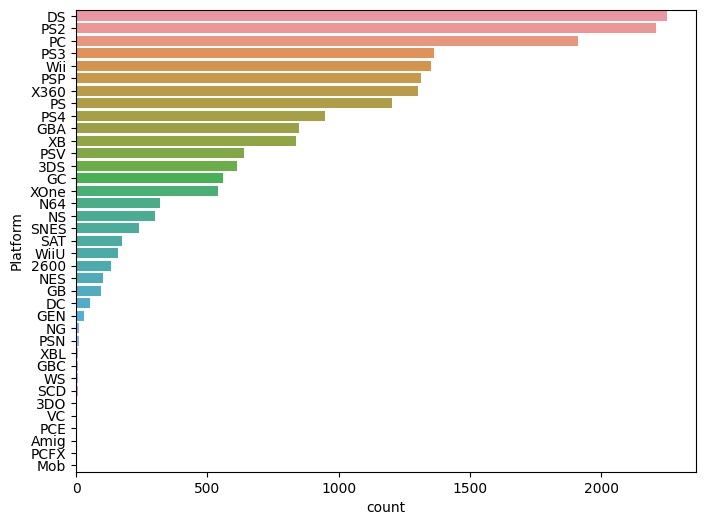

In [12]:
plt.figure(figsize=(8,6))
sns.countplot(data=sales,y='Platform',order=sales['Platform'].value_counts().index)

Over the last couple of decades, majority of games were released for consoles (with DS - Double Screen, PS2, PS3, Wii in the first places) and for PC as the third platform according to popularity.

#### Numeric variables

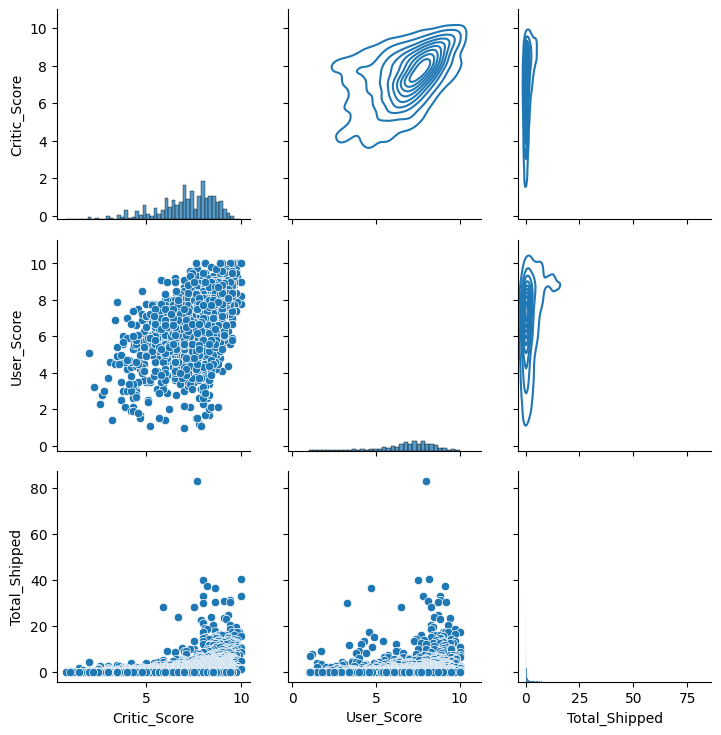

In [13]:
g = sns.PairGrid(data=sales.select_dtypes('number'))
g.map_upper(sns.kdeplot)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)

User scores are positively correlated with critic scores, which could have been anticipated. Games with critic score ~ 5-6 and less were sold in rather small quantities, while sales performance of these with higher ratings is visibly better.

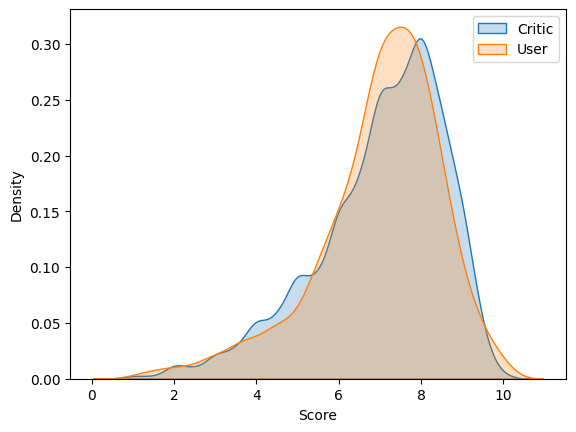

In [14]:
fig, ax = plt.subplots()
sns.kdeplot(sales,x='Critic_Score',fill=True,label='Critic',ax=ax)
sns.kdeplot(sales,x='User_Score',fill=True,label='User',ax=ax)
ax.set_xlabel('Score')
ax.legend()

The distributions of critic and users ratings are quite similar. Distribution of user scores displays a peak somewhat earlier than the distribution of critic scores (remember however, that there were almost twice as much null values in user counts, so the sample is effectively smaller). Both distributions are left-skewed.

Text(0.5, 0, 'Total units sold (mln copies)')

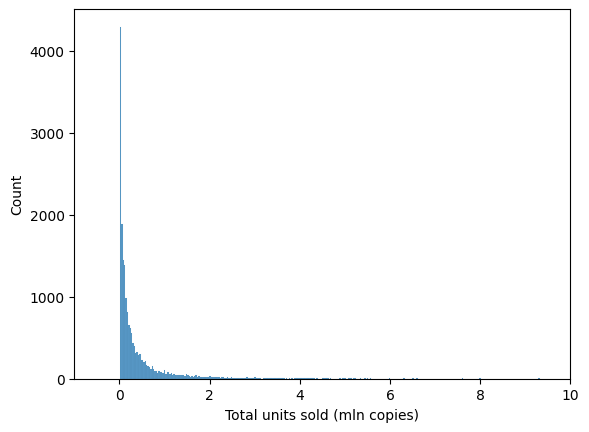

In [15]:
ax = sns.histplot(sales,x='Total_Shipped')
ax.set_xlim([-1,10])
ax.set_xlabel('Total units sold (mln copies)')

The vast majority of games were sold in small to moderate quantities. There are a number of outliers, which most likely represent the greatest hits of all time.

In [16]:
print(f"Min year: {sales['Year'].min().year}, Max year: {sales['Year'].max().year}")

Min year: 1977, Max year: 2020


The dataset includes games from 1977 to 2020, with the majority of the games originating between 2000 and 2016.

How many games were released each year (or at least how many were collected in the dataset)?

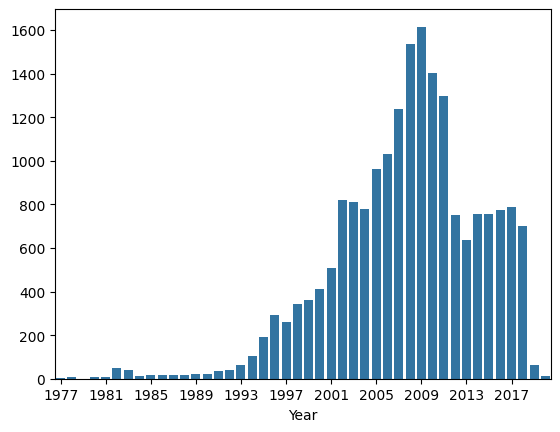

In [17]:
n_games_per_year = sales.groupby(sales['Year'].dt.year)['Name'].count()
ax = sns.barplot(x=n_games_per_year.index, y=n_games_per_year.values,color='tab:blue')
ax.xaxis.set_major_locator(MultipleLocator(4))

## Analysis

### General trends in the gaming market

#### How have the median sales in global gaming market changed over the years?

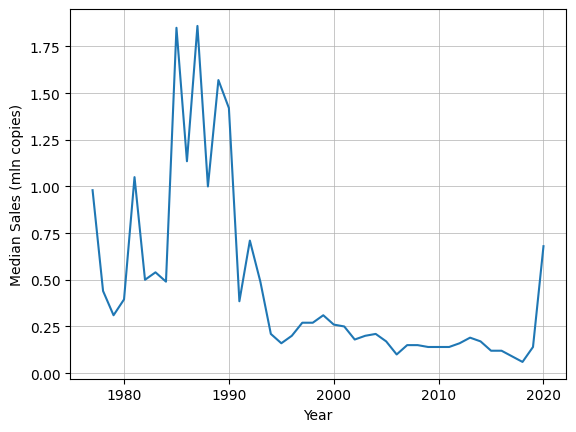

In [18]:
sales_yearly_trend = sales.groupby(sales['Year'].dt.year)['Total_Shipped'].median()
sns.lineplot(sales_yearly_trend)
plt.ylabel('Median Sales (mln copies)')
plt.grid(lw=0.5)

Why median sales and not the sum (or the mean)?

Sum of sales is generally uninformative of the overall condition of the global market in given year, because the more games were released during that year, the higher the total sales will be (actually, it also depends on how the data was collected. Are the sales assigned to a game equal to the amount sold only in the year of the game's release, or is this a cumulative amount up to the day of data collection?).

The histograms of total amount of games sold (Total_shipped) for separate years are very similar (i.e. highly skewed) to the one plotted earlier for entire dataset. Median allows to observe the trend (how many games were sold globally in given year), without being influenced by outliers (greatest hits). Seemingly huge sales in the 80's and 90's are likely an artifact of the dataset itself, which simply doesn't contain many games from these periods (this will happen to be an issue later as well).

What we can say in general with quite high level of confidence is that median (i.e. value describing the global market in the best way) sales since 1995 oscillate around 15 000 - 20 000 copies and tend to decrease.

Let's also differentiate the trend between various platforms:

In [19]:
sales_yearly_trend_platforms = sales.groupby([sales['Year'].dt.year,'Platform'])['Total_Shipped'].agg({'median','count'}).reset_index()

Now we can compare different segments of the gaming industry. Let's investigate how, for instance, the sales for different generations of Playstation have changed over the years:

In [20]:
sales_yearly_ps_generations = sales_yearly_trend_platforms[sales_yearly_trend_platforms['Platform'].isin(['PS','PS2','PS3','PS4'])]

Text(0.5, 0, 'Year')

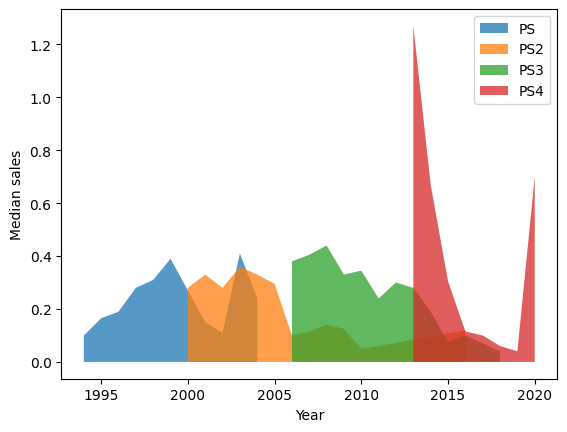

In [21]:
for gen in ['PS','PS2','PS3','PS4']:
    mask = sales_yearly_ps_generations['Platform'] == gen
    plt.fill_between(sales_yearly_ps_generations[mask]['Year'],
                     sales_yearly_ps_generations[mask]['median'],
                     alpha=0.75,
                     label=gen)
plt.legend()
plt.ylabel('Median sales')
plt.xlabel('Year')

The plot clearly separates golden times for different PS generations. A sharp peak in 2020 is an artifact resulting from the low number of games in dataset.

In [22]:
sales_yearly_ps_generations[sales_yearly_ps_generations['Platform'] == 'PS4']

,Year,Platform,median,count
224,2013,PS4,1.270,16
236,2014,PS4,0.670,70
246,2015,PS4,0.305,124
259,2016,PS4,0.115,196
270,2017,PS4,0.100,261
281,2018,PS4,0.060,248
290,2019,PS4,0.040,25
293,2020,PS4,0.700,8


#### Based on critic scores, are games getting worse or better?

Let's investigate two things:
- the number of games with the median critic score (across different platforms) >= 8.0 points
- how the median critic score have changed over the years, with particular focus on PC games

As the distribution of critic scores is skewed, I'm going to use the median instead of the mean to describe central tendency. The are some cases, when mean is more favorable even in presence of outliers ([article](https://towardsdatascience.com/mean-or-median-choose-based-on-the-decision-not-the-distribution-f951215c1376)), but here I'm going to utilize median as "the most representative" value anyway. For example, if a game performed poorly on one platform due to optimization issues and received lower scores as a result, I don't want this to negatively affect the overall impression of the game, assuming it performed better on other platforms.

Text(0, 0.5, 'Number of games')

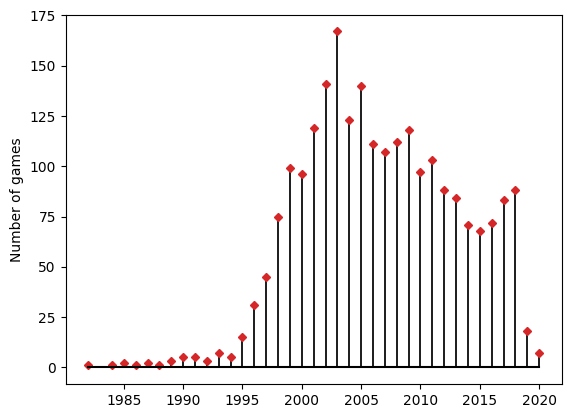

In [23]:
# Calculate the median with respect to the Platform
n_great_games_per_year = sales.groupby([sales['Year'].dt.year,'Name'])['Critic_Score'].median().dropna().reset_index()

# Calculate the median with respect to the Year
n_great_games_per_year = n_great_games_per_year[n_great_games_per_year['Critic_Score'] >= 8.0].groupby('Year')['Name'].count() 

markerline, stemline, baseline, = plt.stem(n_great_games_per_year.index, n_great_games_per_year.values,linefmt='k-', markerfmt='kD', basefmt='k', orientation='vertical')
plt.setp(stemline, linewidth = 1.25)
plt.setp(markerline, markersize = 4, color='tab:red')
plt.ylabel('Number of games')

It seems, that the number of games considered by critics to be great has been decreasing since 2003. The plot also shows, that prior to 1995 there were seemingly only a few good games per year, but again - there is a small number of games released in these years in the dataset in general, so actually the actual fraction of great games might be quite high! Let's check it out:

In [24]:
n_great_games_per_year_joined = pd.merge(left=n_great_games_per_year.reset_index().rename({'Name':'count'},axis=1),
                                         right=n_games_per_year.reset_index().rename({'Name':'count'},axis=1),
                                         on='Year',
                                         how='inner',
                                         suffixes=('_great','_total'))
n_great_games_per_year_joined['%Total'] = (n_great_games_per_year_joined['count_great'] / n_great_games_per_year_joined['count_total'] * 100).round(1)

In [25]:
n_great_games_per_year_joined[(n_great_games_per_year_joined['Year'].between(1977, 1995)) | (n_great_games_per_year_joined['Year'].between(2000, 2010))]

,Year,count_great,count_total,%Total
0,1982,1,47,2.1
1,1984,1,12,8.3
2,1985,2,15,13.3
3,1986,1,18,5.6
4,1987,2,16,12.5
5,1988,1,17,5.9
6,1989,3,20,15.0
7,1990,5,21,23.8
8,1991,5,34,14.7
9,1992,3,40,7.5


Well, maybe the hypothesis wasn't so accurate as I thought. The dataset contains only a few games released between 1977 and 1995, making it challenging to draw confident conclusions about this period. Additionally, games released before 1982 are absent from this summary, suggesting a lack of available reviews for those titles.  On the other hand, in 2001 the percentage of games considered to be "great" by our criteria is quite high (23.2%), considering the total number of games released this year (508).

Actually, the critic score in the dataset is likely an average of scores published by various critics on Metacritic. The information about the number of original reviews would be valuable and could improve conclusions, but unfortunately it's not available. 

How about median critic scores for PC games (specifically between 2000 and 2018)?

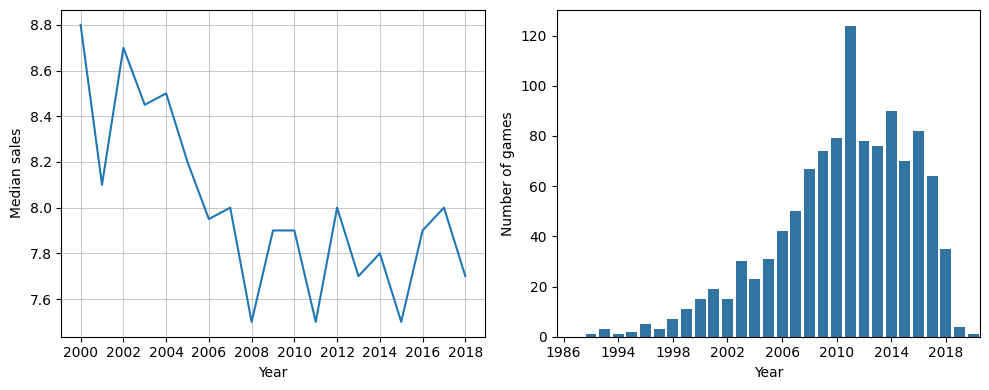

In [26]:
pc_game_sales = sales[sales['Platform'] == 'PC']
pc_game_sales = pc_game_sales.groupby(pc_game_sales['Year'].dt.year)['Critic_Score'].agg(['median','count'])

fig, ax = plt.subplots(figsize=(10,4),ncols=2)
sns.lineplot(pc_game_sales['median'].loc[2000:2018],ax=ax[0])
sns.barplot(x=pc_game_sales['count'].index, y=pc_game_sales['count'].values,color='tab:blue',ax=ax[1])

ax[0].set_ylabel('Median sales')
ax[0].xaxis.set_major_locator(MultipleLocator(2))
ax[0].grid(lw=0.5)

ax[1].set_ylabel('Number of games')
ax[1].xaxis.set_major_locator(MultipleLocator(4))
plt.tight_layout()

I included the second plot (to the right) not without a reason - it depicts the number of games for personal computers released in particular years. The plot to the left shows the variation in median critic score for PC games between 2000 and 2018. The number of games included for some periods (before 2000's and after 2018) are too low to draw meaningful conclusions, in my opinion (for example, the median rating of PC games in 1994 is equal to 9.3 point, but it's only due to the fact, that there is only one PC game from 1993 in the dataset, making the sample unrepresentative! And yes, there were many more PC games back then). Also, many games lack the score, so they were discarded as NaNs. There are just not enough data. 

Side note: 2010 was a king of PC games, at least in terms of number of released titles.

#### Which platforms are loved by the critics?

In [27]:
platforms_filtered_by_game_count = sales.groupby('Platform')['Name'].count().reset_index()
platforms_filtered_by_game_count = platforms_filtered_by_game_count[platforms_filtered_by_game_count['Name'] > 30]['Platform']
sales[sales['Platform'].isin(platforms_filtered_by_game_count)].groupby('Platform')['Critic_Score'].median().nlargest(10)

Platform
GEN     8.80
SNES    8.80
DC      8.60
SAT     8.40
2600    8.30
GB      8.15
PC      7.90
NS      7.80
XB      7.70
XOne    7.70
Name: Critic_Score, dtype: float64

#### How do median sales vary based on critic score?

Let's divide the games into three groups using critic scores:
- low: critic score < 5.5
- medium: 5.5 <= critic score <= 8.5, 
- high: critic score > 8.5

And analyze the median sales in each group. The score I will use to assign a group to particular game will be a median of scores attributed to different platforms if the game was published on more than one. 

In [28]:
def score2group(score):
    if score < 5.5:
        return 'Low'
    elif 5.5 <= score <= 8.5:
        return 'Medium'
    else:
        return 'High'

In [29]:
sales_grouped_by_score = sales.groupby('Name').agg({'Total_Shipped':'sum','Critic_Score':'median'}).dropna().reset_index()
sales_grouped_by_score['Label'] = sales_grouped_by_score['Critic_Score'].apply(lambda x: score2group(x))
sales_grouped_by_score = sales_grouped_by_score.groupby('Label')['Total_Shipped'].agg(['count','median']).reset_index()

Text(0.5, 0, '')

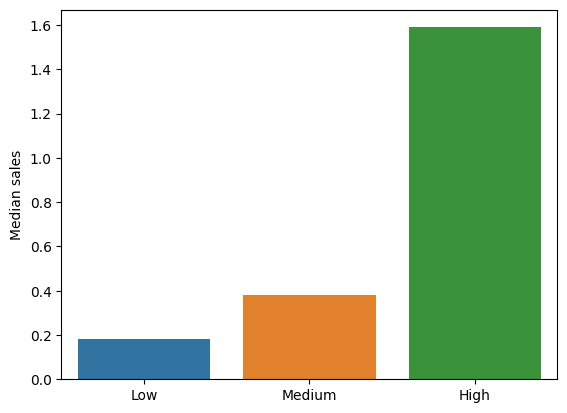

In [30]:
ax = sns.barplot(data=sales_grouped_by_score,x='Label',y='median',order=['Low','Medium','High'])
ax.set_ylabel('Median sales')
ax.set_xlabel('')

In [31]:
sales_grouped_by_score

,Label,count,median
0,High,891,1.59
1,Low,1053,0.18
2,Medium,4628,0.38


As we might expect the median sales of a game vary, depending on the median critic score (and thus assigned label). The difference between medium and high groups is large, but it also depends on how we define "Medium" and "High".

How much higher are median sales of top-rated games in comparison to the average and bad ones?

In [32]:
median_sales = sales_grouped_by_score['median'] 
print(f"Comparison with mediocre games: {(median_sales.iloc[0] - median_sales.iloc[2]) / median_sales.iloc[2] * 100:.1f}% higher median sales")
print(f"Comparison with lowest-rated games: {(median_sales.iloc[0] - median_sales.iloc[1]) / median_sales.iloc[1] * 100:.1f}% higher median sales")

Comparison with mediocre games: 318.4% higher median sales
Comparison with lowest-rated games: 783.3% higher median sales


#### Identify top 5% of the games according to critic score per year with an additional restriction, that their median score can't be lower than 8.5 points. 

In [33]:
top_rated_games_mask = sales.groupby(['Name'])['Critic_Score'].median() >= 8.5
top_rated_games = sales[sales['Name'].isin(top_rated_games_mask.index)].dropna(subset='Critic_Score')
top_rated_games['rank'] = top_rated_games.groupby(['Year'])['Critic_Score'].rank(pct=True,ascending=True)
top_rated_games = top_rated_games[top_rated_games['rank'] >= 0.95].sort_values(by='Year',ascending=False)

In [34]:
top_rated_games[['Name','Platform','Year']]

,Name,Platform,Year
1656,Persona 5 Royal,PS4,2020-01-01
5824,Shovel Knight,NS,2019-01-01
1163,Forza Horizon 4,XOne,2018-01-01
541,Assassin's Creed Odyssey,PS4,2018-01-01
1130,Minecraft,NS,2018-01-01
...,...,...,...
714,Super Mario Bros. 2 (FDS),NES,1986-01-01
1,Super Mario Bros.,NES,1985-01-01
1476,F1 Race,NES,1984-01-01
139,Pac-Man,2600,1982-01-01


#### Finally, what are 3 top-selling and 3 top-rated games of all times?

In [35]:
best_selling_games = sales.groupby('Name')['Total_Shipped'].sum().nlargest(3).index.tolist()

# Use rank to allow for ex-aequo places
best_rated_games = sales.groupby('Name')['Critic_Score'].median().rank(method='dense',ascending=False)
best_rated_games = best_rated_games[best_rated_games <= 3].index.tolist()

print(f"Top selling games of all times: {', '.join(best_selling_games)}")
print(f"Top rated games of all times: {', '.join(best_rated_games)}")

Top selling games of all times: Wii Sports, Grand Theft Auto V, Minecraft
Top rated games of all times: Final Fantasy II, Final Fight, Grand Theft Auto IV, Red Dead Redemption: Undead Nightmare, Super Mario Bros., Super Mario Kart, Super Mario Odyssey, The Legend of Zelda: Breath of the Wild, The Legend of Zelda: Ocarina of Time


When were they released?

In [36]:
sales[sales['Name'].isin(best_selling_games)][['Name','Platform','Year']].sort_values(by='Year')

,Name,Platform,Year
0,Wii Sports,Wii,2006-01-01
5,Minecraft,PC,2010-01-01
22,Grand Theft Auto V,PS3,2013-01-01
40,Grand Theft Auto V,X360,2013-01-01
65,Minecraft,X360,2013-01-01
23,Grand Theft Auto V,PS4,2014-01-01
122,Grand Theft Auto V,XOne,2014-01-01
183,Minecraft,PS4,2014-01-01
193,Minecraft,PS3,2014-01-01
228,Minecraft,XOne,2014-01-01


In [37]:
sales[sales['Name'].isin(best_rated_games)][['Name','Platform','Year']].sort_values(by='Year')

,Name,Platform,Year
1,Super Mario Bros.,NES,1985-01-01
3164,Final Fantasy II,NES,1988-01-01
1285,Final Fantasy II,SNES,1991-01-01
1545,Final Fight,SNES,1991-01-01
121,Super Mario Kart,SNES,1992-01-01
142,The Legend of Zelda: Ocarina of Time,N64,1998-01-01
7552,Final Fantasy II,WS,2001-01-01
85,Grand Theft Auto IV,X360,2008-01-01
93,Grand Theft Auto IV,PS3,2008-01-01
2812,Grand Theft Auto IV,PC,2008-01-01


#### Conclusions

Through analysis we can conclude, that:
- The global gaming market is dominated by consoles, with PC taking third place in terms of the number of games released. Among the top-rated games of all time, only one (Grand Theft Auto IV) was released for personal computers, in addition to versions for the Xbox 360 and PlayStation 3.
- The year 2003 had the highest number of great games (median score across all platforms >= 8.0). A decline in the number of good games is observed in subsequent years.
- Sales are associated with critic scores. Median sales of top-rated games are 320% higher than the median sales of games with average ratings and 780% higher than the sales of the lowest-rated games.